# Evaluation notebook

## Load the necessary libraries

In [1]:
import os
import json
import sklearn.metrics 
import cv2
import tensorflow as tf
from matplotlib  import pyplot as plt
import pandas as pd
import numpy as np
from scripts.data import prepare_data
from scripts.data_class import CustomDataGen
from statistics import mean, median
import seaborn as sns
from sklearn.model_selection import train_test_split 
from itertools import chain

In [2]:
def estimate_scale_df(model, df, color=False, patch_width=5):
    ''' Estimate scales of keypoints for an image.
    
    For the image, selects keypoints from the test dataframe and creates a filtered dataframe. 
    The selected keypoints are then passed through a chosen model to obtain the predictions. The predicted scales 
    are stored back on to the filtered dataframe. 
    
    Parameters
    ----------
    image
        Input image.
    model
        Trained NN model.    
        
    Returns
    -------
    df
        Dataframe with estimated scales for an image.
        
    '''
    
    # Set the patch_width according to the input of the trained model
    patch_width = np.int32(model.input_shape[1]/2)     
    input_shape = (patch_width*2, patch_width*2, model.input_shape[-1])
    
    # Prepare data for evaluation of a trained model
    testgen =  CustomDataGen(df,
                         X_col={'path':'Filename', 'cord':'Co-ordinates'},
                         y_col={'size': 'Keypoint Size'},
                         batch_size=len(df), input_size=input_shape,
                         patch_width=patch_width,
                         color=color) #prepare_data(df, patch_width, batch_size=len(df))
    
    test_data, test_labels = testgen[0]
    # Estimate scales of the patches from the test dataset for model 1
    predictions = model.predict(test_data) 
    pred = list(predictions) # convert array of tensors to list of tensors
    df['Predicted Size'] = np.vstack(pred) # Store the estimated sizes back on to the filtered dataframe
    
    return  test_data, test_labels,  df # returns a dataframe with estimated scales appended for an image

In [3]:
# Load the test dataset stored on the disk
df_test = pd.read_json('/cdtemp/dheerajr/Datasets/SIFT/Test/Test_1000kp.json')
df_test = df_test.sort_values(by='Keypoint Size', ignore_index=True)

df_main = pd.read_json('/cdtemp/dheerajr/Datasets/SIFT/Train/Train_hist_filt/Train_histfil_5000.json')

train_df, val_df = train_test_split(df_main, random_state=1, test_size=0.25, shuffle=True)


In [7]:
# Load trained model

model = tf.keras.models.load_model('saved_models/Training_class/SIFT/SIFT_res34_Train_hf_5000rgb_kp_+15_mae_rmsprop')
patch_width = np.int32(model.input_shape[1]/2)     
input_shape = (patch_width*2, patch_width*2, model.input_shape[-1])

valgen = CustomDataGen(val_df,
                         X_col={'path':'Filename', 'cord':'Co-ordinates'},
                         y_col={'size': 'Keypoint Size'},
                         batch_size=128, input_size=input_shape,
                         patch_width=patch_width, color=True)

In [8]:
model.loss, model.optimizer, input_shape

(<function keras.losses.mean_absolute_error(y_true, y_pred)>,
 (88, 88, 3))

In [ ]:
df_val_mini = pd.DataFrame()
pred = []
true = []

for i in range(len(valgen)):
    val_data, val_labels = valgen[i]
    predictions = model.predict(val_data)
    pred.append(predictions)
    true.append(val_labels)

pred = list(chain.from_iterable(pred))
true = list(chain.from_iterable(true))
df_val_mini['Keypoint Size'] =  true
df_val_mini['Predicted Size'] =  np.vstack(pred)

rmse_val = sklearn.metrics.mean_squared_error(df_val_mini['Keypoint Size'], 
                                              df_val_mini['Predicted Size'], squared=False)

In [10]:
# Prepare test data, labels, and subdivide test dataset
test_data, test_labels, df_test = estimate_scale_df(model, df=df_test, color=True)

df_small = df_test.nsmallest(n=333, columns='Keypoint Size') #.reset_index(drop=True)
df_medium = df_test.drop(df_small.index).nsmallest(n=333, columns='Keypoint Size') #.reset_index(drop=True)
df_large = df_test.drop(df_small.index).drop(df_medium.index).reset_index(drop=True)
df_small = df_small.reset_index(drop=True)
df_medium = df_medium.reset_index(drop=True)

2023-04-10 23:43:14.175843: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 92928000 exceeds 10% of free system memory.
2023-04-10 23:43:14.257079: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 92928000 exceeds 10% of free system memory.


In [11]:
rmse_test = sklearn.metrics.mean_squared_error(df_test['Keypoint Size'], 
                                              df_test['Predicted Size'], squared=False)
rmse_test

6.322758965297269

In [12]:
# Calculate accuracy

df_names = ['df_small', 'df_medium', 'df_large']
df = [df_small, df_medium, df_large]
threshold_factor = 0.10
acc_list = []

for j in range(len(df)):
    error_abs = []
    for i in range(len(df[j])):
        thr_fact = threshold_factor            
        threshold = thr_fact*df[j].iloc[i]['Keypoint Size']
        error_1 = abs(df[j].iloc[i]['Keypoint Size']-df[j].iloc[i]['Predicted Size'])
        error_abs.append(abs(error_1) < threshold)
        
    numCorrect = sum(error_abs) 
    acc = np.float32(numCorrect/len(df[j])) # list of accuracy scores for different bins of sizes.
    acc_list.append(acc)

In [13]:
acc_list # Accuracy at 10% threshold

[0.3933934, 0.8198198, 0.79041916]

In [14]:
# To sort the dataframes based on the difference between ground-truth and predicted scales

df_small['Act Diff'] = np.abs(df_small['Keypoint Size']-df_small['Predicted Size'])
df_small = df_small.sort_values(by='Act Diff', ascending=False).reset_index(drop=True)

df_medium['Act Diff'] = np.abs(df_medium['Keypoint Size']-df_medium['Predicted Size'])
df_medium = df_medium.sort_values(by='Act Diff', ascending=False).reset_index(drop=True)

df_large['Act Diff'] = np.abs(df_large['Keypoint Size']-df_large['Predicted Size'])
df_large = df_large.sort_values(by='Act Diff', ascending=False).reset_index(drop=True)

In [15]:
df_small

Filename Co-ordinates  \
0    /cdtemp/dheerajr/Images-Test/2008_000584.jpg    [437, 24]   
1    /cdtemp/dheerajr/Images-Test/2008_000630.jpg    [45, 129]   
2    /cdtemp/dheerajr/Images-Test/2008_000690.jpg    [55, 113]   
3    /cdtemp/dheerajr/Images-Test/2008_000505.jpg   [363, 172]   
4    /cdtemp/dheerajr/Images-Test/2008_000683.jpg   [107, 318]   
..                                            ...          ...   
328  /cdtemp/dheerajr/Images-Test/2008_000634.jpg   [253, 355]   
329  /cdtemp/dheerajr/Images-Test/2008_000636.jpg   [160, 256]   
330  /cdtemp/dheerajr/Images-Test/2008_000501.jpg    [38, 160]   
331  /cdtemp/dheerajr/Images-Test/2008_000531.jpg    [453, 24]   
332  /cdtemp/dheerajr/Images-Test/2008_000547.jpg    [28, 364]   

     Characteristic Orientation  Octave  Keypoint Size  Predicted Size  \
0                    179.120499      -1       2.490266       50.957230   
1                     33.869362      -1       1.809980       41.204861   
2                    119.727631      -1       2.634094       40.810196   
3                    172.236328       0       5.816698       36.360550   
4                    170.006073      -1       1.887853       31.316256   
..                          ...     ...            ...             ...   
328                   70.629410       0       4.725920        4.735360   
329                  263.314911      -1       2.536384        2.542897   
330                  277.322449       0       3.696758        3.691523   
331                   40.149937      -1       2.058177        2.062208   
332                   14.115791       0       4.169195        4.168544   

      Act Diff  
0    48.466964  
1    39.394880  
2    38.176102  
3    30.543852  
4    29.428403  
..         ...  
328   0.009440  
329   0.006513  
330   0.005235  
331   0.004031  
332   0.000651  

[333 rows x 7 columns]

In [26]:
def zoom_at(img, kp_size, zoom_factor=1, angle=0, coord=None):
    
    cy, cx = [ i/2 for i in img.shape[0:2] ] if coord is None else coord[::-1]
    
    rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom_factor)
    zoomed_img = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    new_kp_size = kp_size*zoom_factor
    
    return zoomed_img, new_kp_size

In [39]:
testgen_dfsmall =  CustomDataGen(df_small,
                         X_col={'path':'Filename', 'cord':'Co-ordinates'},
                         y_col={'size': 'Keypoint Size'},
                         batch_size=len(df_small), input_size=input_shape,
                         patch_width=patch_width,
                         color=True) 
    
test_data_small, test_labels_small = testgen_dfsmall[0]

testgen_dfmed =  CustomDataGen(df_medium,
                         X_col={'path':'Filename', 'cord':'Co-ordinates'},
                         y_col={'size': 'Keypoint Size'},
                         batch_size=len(df_small), input_size=input_shape,
                         patch_width=patch_width,
                         color=True) 
    
test_data_med, test_labels_med = testgen_dfmed[0]
test_data_med = test_data_med.astype('float32')

testgen_dflarge =  CustomDataGen(df_large,
                         X_col={'path':'Filename', 'cord':'Co-ordinates'},
                         y_col={'size': 'Keypoint Size'},
                         batch_size=len(df_large), input_size=input_shape,
                         patch_width=patch_width,
                         color=True) #prepare_data(df, patch_width, batch_size=len(df))
    
test_data_large, test_labels_large = testgen_dflarge[0]
test_data_large = test_data_large.astype('float32')

In [42]:
test_zoom_2_arr = []
test_label_2_arr = []

for i in range(len(test_data_small)):
    test_zoom_2, test_label_2 = zoom_at(test_data_small[i], test_labels_small[i], zoom_factor=2.0)
    test_zoom_2_arr.append(test_zoom_2)
    test_label_2_arr.append(test_label_2)
    
test_zoom_2_arr = np.array([np.array(xi,  dtype=np.float32) for xi in test_zoom_2_arr])
test_label_2_arr = np.array(test_label_2_arr)

test_zoom_4_arr = []
test_label_4_arr = []

for i in range(len(test_data_small)):
    test_zoom_4, test_label_4 = zoom_at(test_data_small[i], test_labels_small[i], zoom_factor=4.0)
    test_zoom_4_arr.append(test_zoom_4)
    test_label_4_arr.append(test_label_4)
    
test_zoom_4_arr = np.array([np.array(xi,  dtype=np.float32) for xi in test_zoom_4_arr])
test_label_4_arr = np.array(test_label_4_arr)

predictions = model.predict(test_zoom_2_arr) 
df_small['Predicted Size (factor 2)'] = predictions/2.0

predictions = model.predict(test_zoom_4_arr) 
df_small['Predicted Size (factor 4)'] = predictions/4.0



In [43]:
test_zoom_2_arr = []
test_label_2_arr = []

for i in range(len(test_data_med)):
    test_zoom_2, test_label_2 = zoom_at(test_data_med[i], test_labels_med[i], zoom_factor=2.0)
    test_zoom_2_arr.append(test_zoom_2)
    test_label_2_arr.append(test_label_2)
    
test_zoom_2_arr = np.array([np.array(xi,  dtype=np.float32) for xi in test_zoom_2_arr])
test_label_2_arr = np.array(test_label_2_arr)

test_zoom_4_arr = []
test_label_4_arr = []

for i in range(len(test_data_med)):
    test_zoom_4, test_label_4 = zoom_at(test_data_med[i], test_labels_med[i], zoom_factor=4.0)
    test_zoom_4_arr.append(test_zoom_4)
    test_label_4_arr.append(test_label_4)
    
test_zoom_4_arr = np.array([np.array(xi,  dtype=np.float32) for xi in test_zoom_4_arr])
test_label_4_arr = np.array(test_label_4_arr)

predictions = model.predict(test_zoom_2_arr) 
df_medium['Predicted Size (factor 2)'] = predictions/2.0

predictions = model.predict(test_zoom_4_arr) 
df_medium['Predicted Size (factor 4)'] = predictions/4.0



In [35]:
test_zoom_2_arr = []
test_label_2_arr = []

for i in range(len(test_data_large)):
    test_zoom_2, test_label_2 = zoom_at(test_data_large[i], test_labels_large[i], zoom_factor=2.0)
    test_zoom_2_arr.append(test_zoom_2)
    test_label_2_arr.append(test_label_2)
    
test_zoom_2_arr = np.array([np.array(xi,  dtype=np.float32) for xi in test_zoom_2_arr])
test_label_2_arr = np.array(test_label_2_arr)

test_zoom_4_arr = []
test_label_4_arr = []

for i in range(len(test_data_large)):
    test_zoom_4, test_label_4 = zoom_at(test_data_large[i], test_labels_large[i], zoom_factor=4.0)
    test_zoom_4_arr.append(test_zoom_4)
    test_label_4_arr.append(test_label_4)
    
test_zoom_4_arr = np.array([np.array(xi,  dtype=np.float32) for xi in test_zoom_4_arr])
test_label_4_arr = np.array(test_label_4_arr)

predictions = model.predict(test_zoom_2_arr) 
df_large['Predicted Size (factor 2)'] = predictions/2.0

predictions = model.predict(test_zoom_4_arr) 
df_large['Predicted Size (factor 4)'] = predictions/4.0



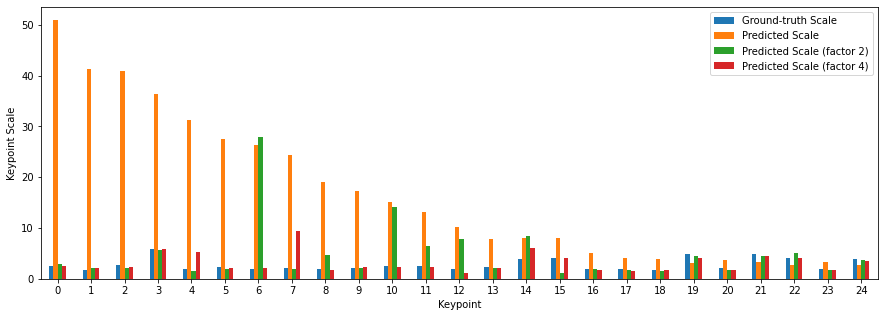

In [41]:
for i in range(0, 25, 25):    
    df_test_plot = df_small[['Keypoint Size', 'Predicted Size', 
                            'Predicted Size (factor 2)','Predicted Size (factor 4)']][i:i+25]
    _ = df_test_plot.plot(kind='bar', y=['Keypoint Size', 'Predicted Size', 
                                         'Predicted Size (factor 2)', 
                                         'Predicted Size (factor 4)'], rot=0,
                          xlabel='Keypoint', ylabel='Keypoint Scale', figsize=(15,5))
    
    plt.legend(['Ground-truth Scale', 'Predicted Scale', 'Predicted Scale (factor 2)', 'Predicted Scale (factor 4)'])

In [44]:
df_names = ['df_small', 'df_medium', 'df_large']
df = [df_small, df_medium, df_large]
threshold_factor = 0.1


def accuracy_measure(df, threshold_factor, original=True, scaled_2=True, scaled_4=True):
    # Loop over the datasets.
    acc_list = []
    for j in range(len(df)):
        error_abs = []
        
        
        # Loop over the length of each dataset
        for i in range(len(df[j])):
            thr_fact = threshold_factor            
            threshold = thr_fact*df[j].iloc[i]['Keypoint Size']
            error_1 = abs(df[j].iloc[i]['Keypoint Size']-df[j].iloc[i]['Predicted Size'])
            error_2 = abs(df[j].iloc[i]['Keypoint Size']-df[j].iloc[i]['Predicted Size (factor 2)'])
            error_3 = abs(df[j].iloc[i]['Keypoint Size']-df[j].iloc[i]['Predicted Size (factor 4)'])
        
        #print(error_1, error_2, threshold)
            if (original == True) and (abs(error_1) < threshold):
                error_abs.append(abs(error_1) < threshold)
            
            elif (scaled_2 == True) and (abs(error_2) < threshold):
                error_abs.append(abs(error_2)<threshold)
            
            elif (scaled_4 == True) and (abs(error_3) < threshold):
                error_abs.append(abs(error_3) < threshold)
        
        numCorrect = sum(error_abs) 
        acc = np.float32(numCorrect/len(df[j])) # list of accuracy scores for different bins of sizes.
        acc_list.append(acc)
        
        #print('Dataset:', df_names[j], '| Accuracy: ', str(round(acc*100, 2)) + '%', 
              #'| Thresholding factor:', str(thr_fact*100)+'%')
        
    return acc_list


In [53]:
toggle = [False, True] 
acc = []
tru_fal = []
for k in range(0,2):
    for j in range(0,2):
        #for i in range(0,2):
        acc.append(accuracy_measure(df, threshold_factor=threshold_factor, original=toggle[i], 
                             scaled_2=toggle[j], scaled_4=toggle[k]))
        tru_fal.append((toggle[i], toggle[j], toggle[k]))

res_df = pd.DataFrame()
res_df['Original'] = [b[0] for b in tru_fal]
res_df['Scaled by 2'] = [b[1] for b in tru_fal]
res_df['Scaled by 4'] = [b[2] for b in tru_fal]
res_df['Accuracy (test_small)'] = [np.round(i[0]*100, 2) for i in acc]
res_df['Accuracy (test_medium)'] =[np.round(i[1]*100, 2) for i in acc]
res_df['Accuracy (test_large)'] =[np.round(i[2]*100, 2) for i in acc]

In [54]:
res_df = res_df.drop([2]) #1,3,7
res_df

Original  Scaled by 2  Scaled by 4  Accuracy (test_small)  \
0      True        False        False                  39.34   
1      True         True        False                  66.07   
3      True         True         True                  81.08   

   Accuracy (test_medium)  Accuracy (test_large)  
0                   81.98                  79.04  
1                   93.39                  82.63  
3                   94.89                  83.23

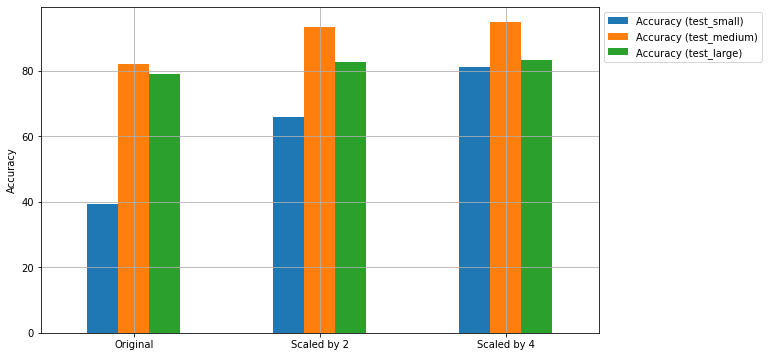

In [55]:
res_df.plot(kind='bar', y=['Accuracy (test_small)', 'Accuracy (test_medium)', 'Accuracy (test_large)'],
                           ylabel='Accuracy', fontsize=10, figsize=(10,6))
plt.xticks(ticks=(0,1,2), labels=['Original', 'Scaled by 2', 'Scaled by 4'], rotation=0, fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid()

## Heatmap visualization

In [917]:
def act_vis(test_data, df, kp = 332, title='df', zoom=False):
    pos = df.iloc[kp]['Co-ordinates']
    act_list = []
    row, col = 1, 3
    fig, ax= plt.subplots(row, col, figsize=(20, 5))
    
    image = cv2.imread(df.iloc[kp]['Filename'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.circle(image, pos, int(df.iloc[kp]['Keypoint Size']), color=(255, 0, 0), thickness=1)
    ax[0].imshow(image)
    
    ax[0].title.set_text('Input Image')
    
    patch =  np.float32(test_data[kp]) #*255
    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    pos = (int(np.round(patch.shape[0]/2)), int(np.round(patch.shape[1]/2)))
    
    patch = cv2.circle(patch, pos, int(df.iloc[kp]['Keypoint Size']), color=(255, 0, 0), thickness=1)
    patch = cv2.circle(patch, pos, int(df.iloc[kp]['Predicted Size (factor 2)']), color=(0, 0, 255), thickness=1)   
    ax[1].imshow(patch)    
    
    ax[1].title.set_text('Keypoint Patch')
    
    if zoom==True:
        df.iloc[kp:kp+1].plot(kind='bar', y=['Keypoint Size', 'Predicted Size', 'Predicted Size (factor 2)', 
                                         'Predicted Size (factor 4)'], rot=0,
                              xlabel='Keypoint', ylabel='Keypoint Scale', 
                              ax=ax[2], legend=['Ground-truth Scale', 'Predicted Scale'])
        plt.legend(['Ground-truth Scale', 'Predicted Scale (original)', 'Predicted Scale (factor 2)', 
                                         'Predicted Scale (factor 4)'], bbox_to_anchor=(1.0, 1.0))
        
    else:
        df.iloc[kp:kp+1].plot(kind='bar', y=['Keypoint Size', 'Predicted Size'], rot=0,
                          xlabel='Keypoint', ylabel='Keypoint Scale', ax=ax[2], 
                              legend=['Ground-truth Scale', 'Predicted Scale'])
    
        plt.legend(['Ground-truth Scale', 'Predicted Scale'], bbox_to_anchor=(1.45, 1.0))
        
    plt.title(title)
    
    
    layer_outputs = [layer.output for layer in model.layers]
    # Extracts the outputs of the top 12 layers
    
    activation_model = tf.keras.models.Model(inputs=model.input, 
                                             outputs=layer_outputs) 
    # Creates a model that will return these outputs, given the model input
    
    activations = activation_model.predict(test_data[kp:kp+1]) 
    # Returns a list of five Numpy arrays: one array per layer activation
    
    a = 3
    b = 11
    c = 1
    fig = plt.figure(figsize = (46,12))

    for i in range(len(layers_act)):
        if 'Activation' in str(layers_act[i]): 
            acti = activations[i]
            acti = np.squeeze(acti)
            acti = np.mean(acti, axis=2)
            acti = cv2.resize(acti, (input_shape[0], input_shape[1]))
            plt.subplot(a, b, c)
            plt.title('Activation layer_'+str(i))
            plt.imshow(acti, vmin=0, vmax=1, cmap='jet') 
            plt.axis('off')
            plt.colorbar(fraction=0.046, pad=0.04, cmap='jet')
            c = c+1
            act_list.append(acti)
            
    return act_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


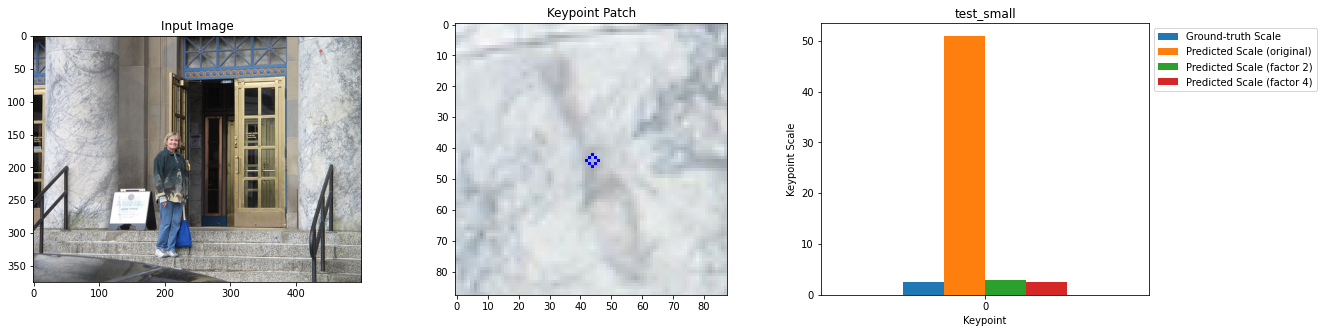

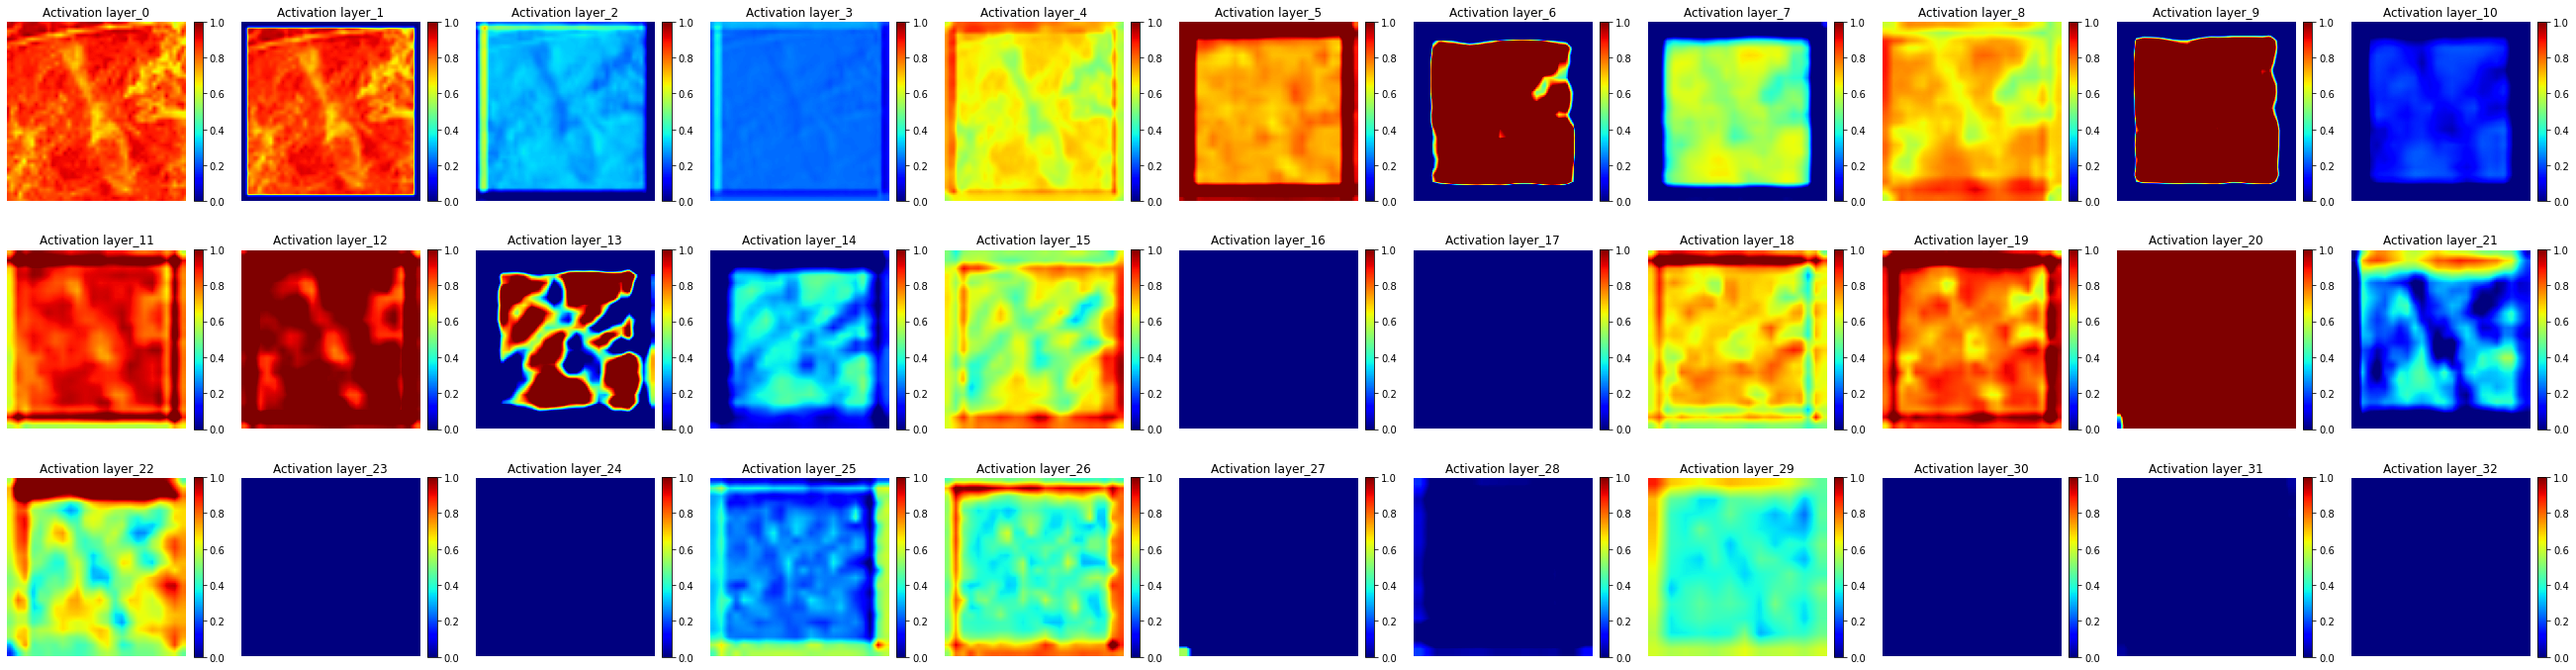

In [920]:
i = 0
#act_list = act_vis(test_data_small, df_small, kp=i, title='test_small', zoom=False)
act_list_2 = act_vis(test_data_zoom_2, df_small, kp=i, title='test_small', zoom=True)
#act_list_4 = act_vis(test_data_zoom_4, df_small, kp=i, title='test_small', zoom=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


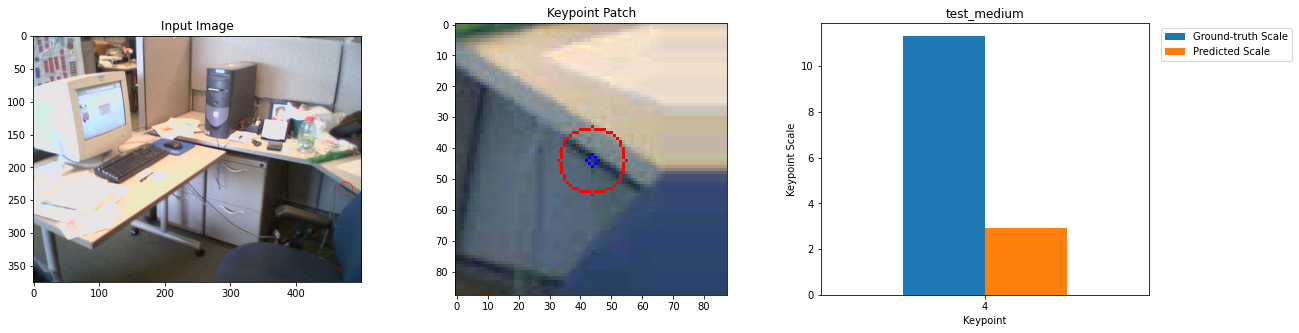

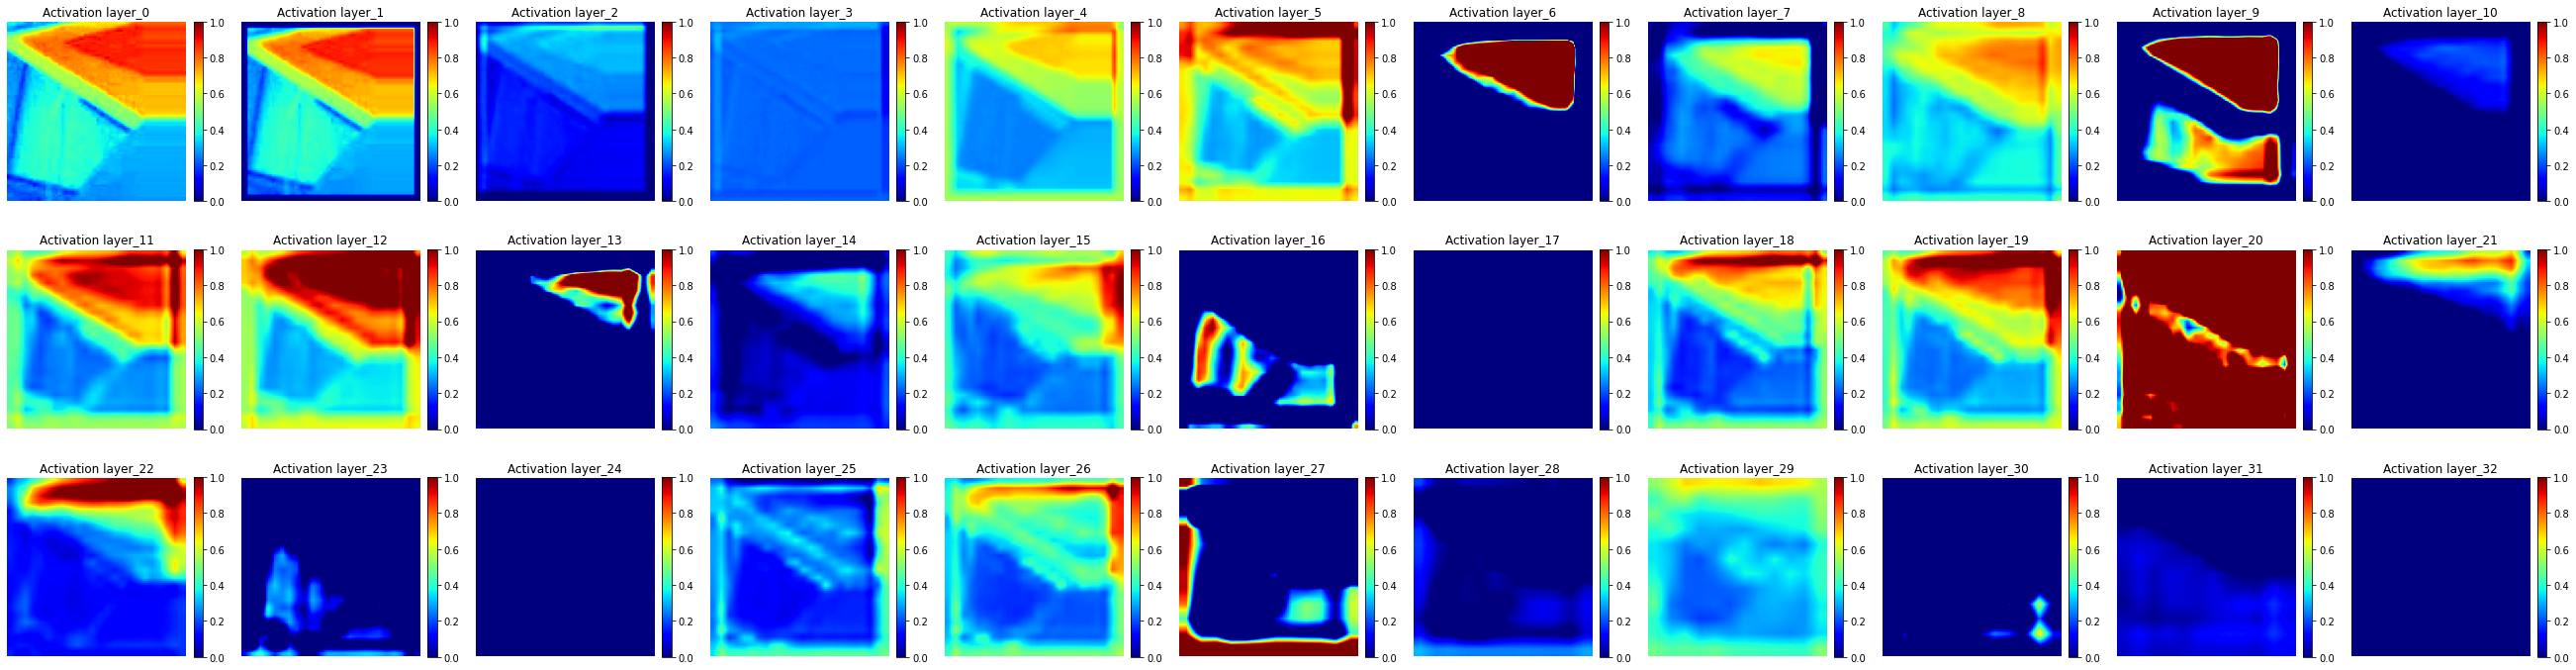

In [890]:
i = 4 #42 #2 #37

act_list = act_vis(test_data_med, df_medium, kp=i, title='test_medium', zoom=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


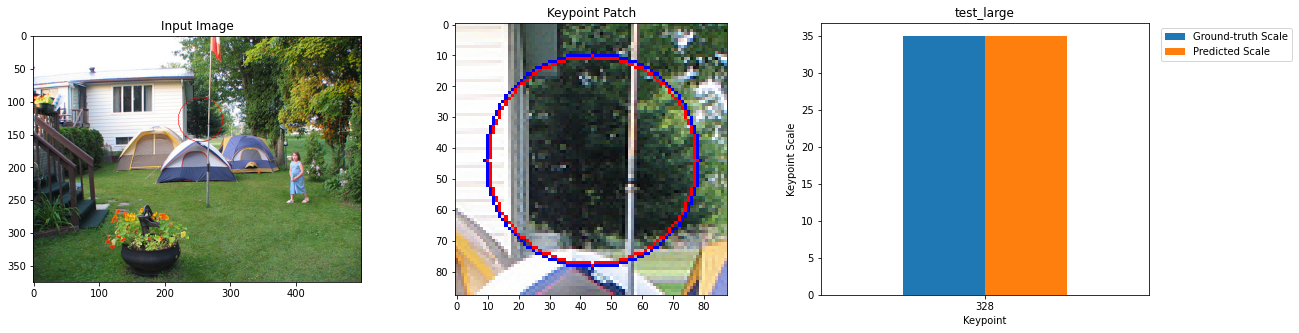

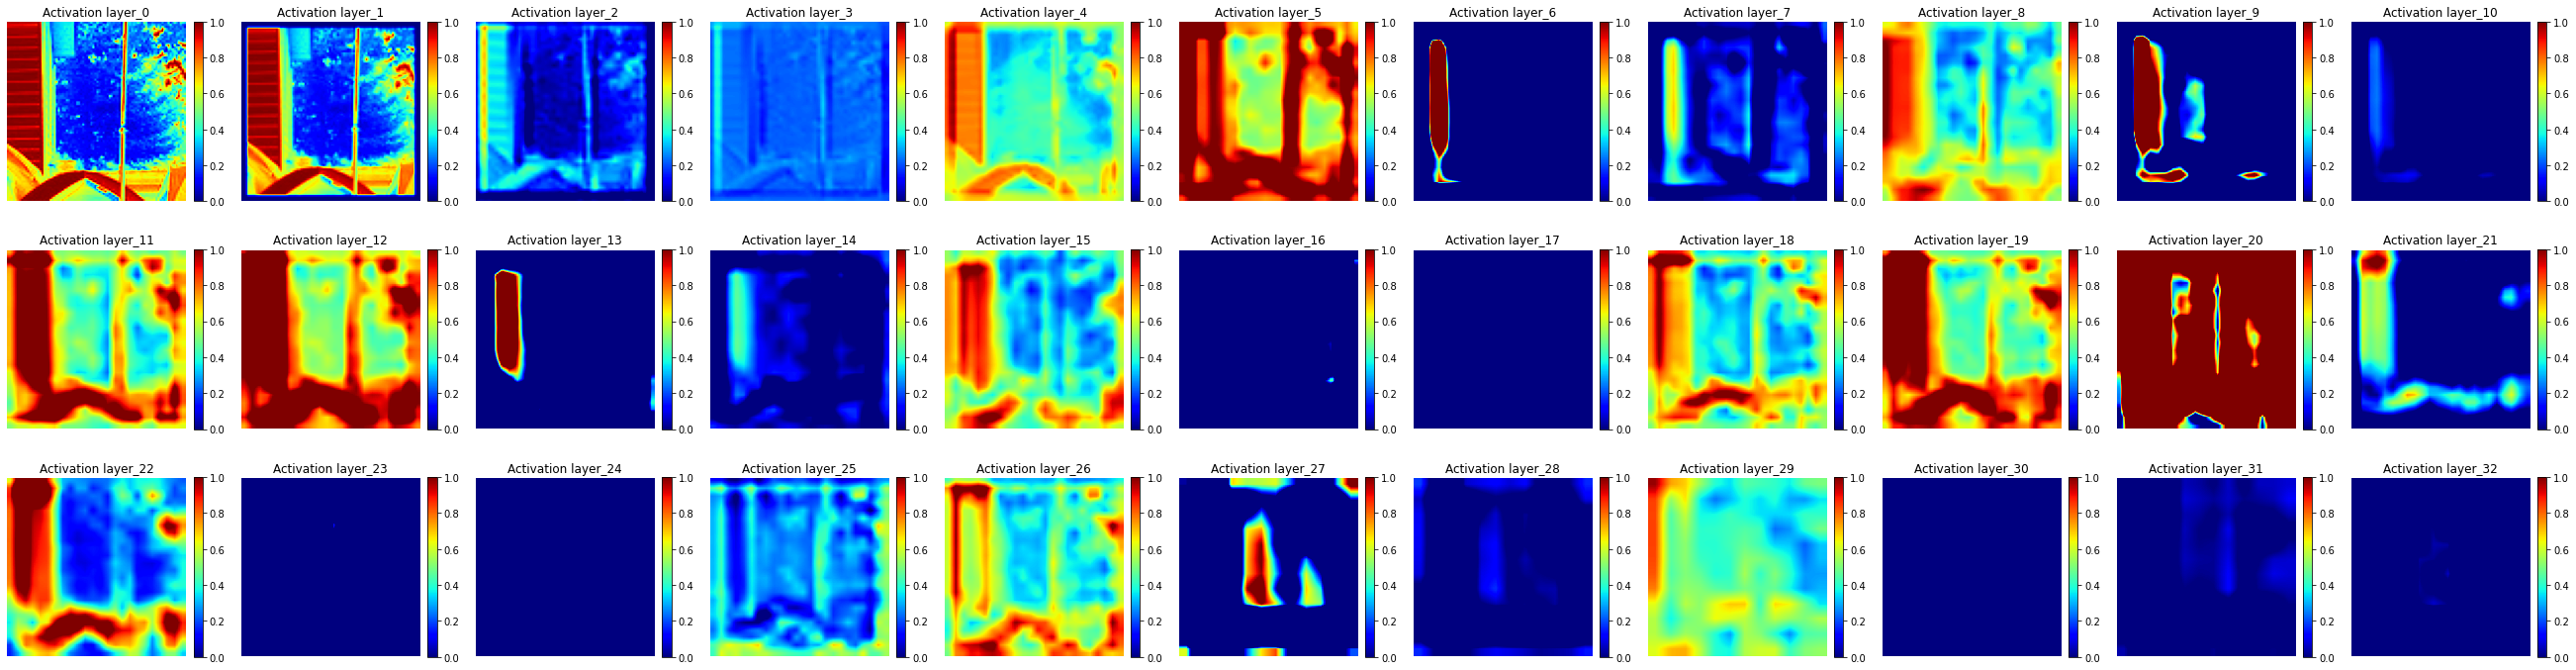

In [901]:
i = 328 #42 #2 #37

act_list = act_vis(test_data_large, df_large, kp=i, title='test_large', zoom=False)

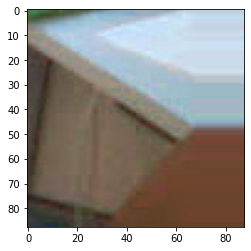

In [834]:
plt.imshow(np.int32(test_data_med[4]*255))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


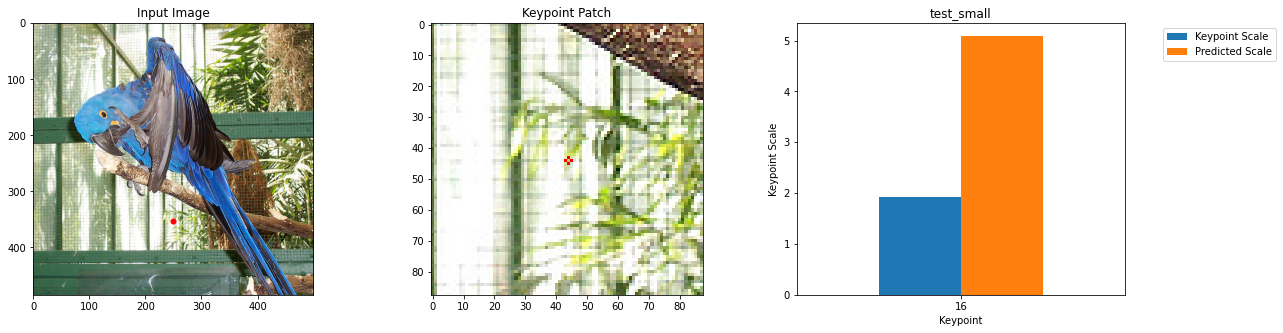

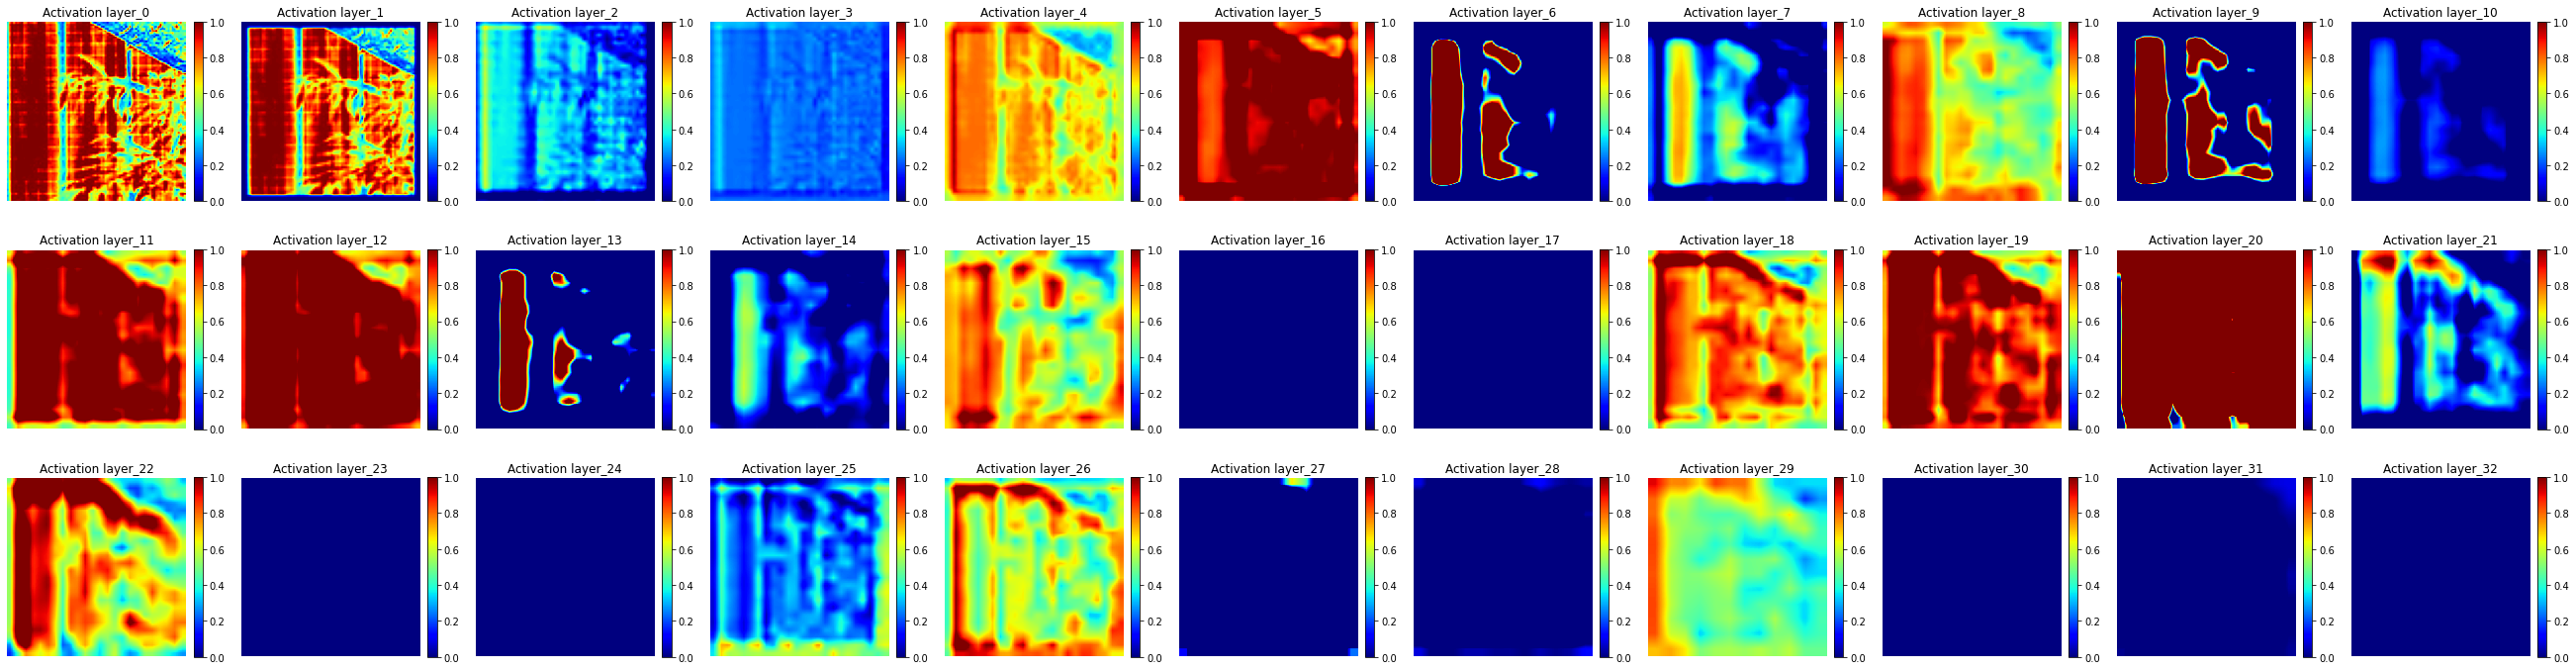

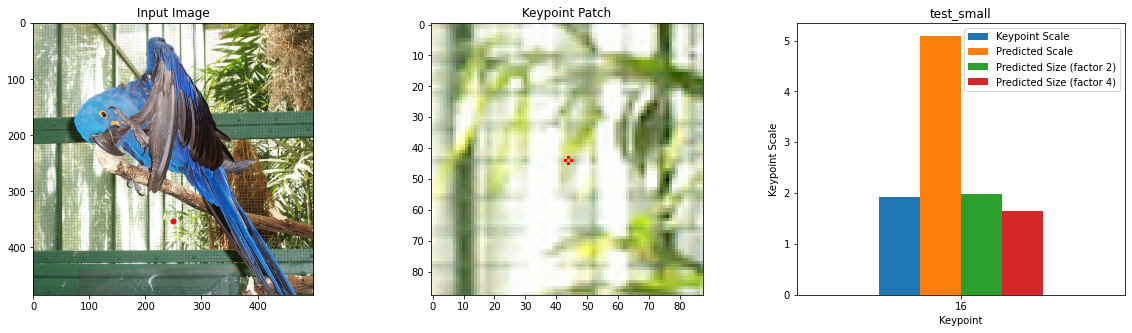

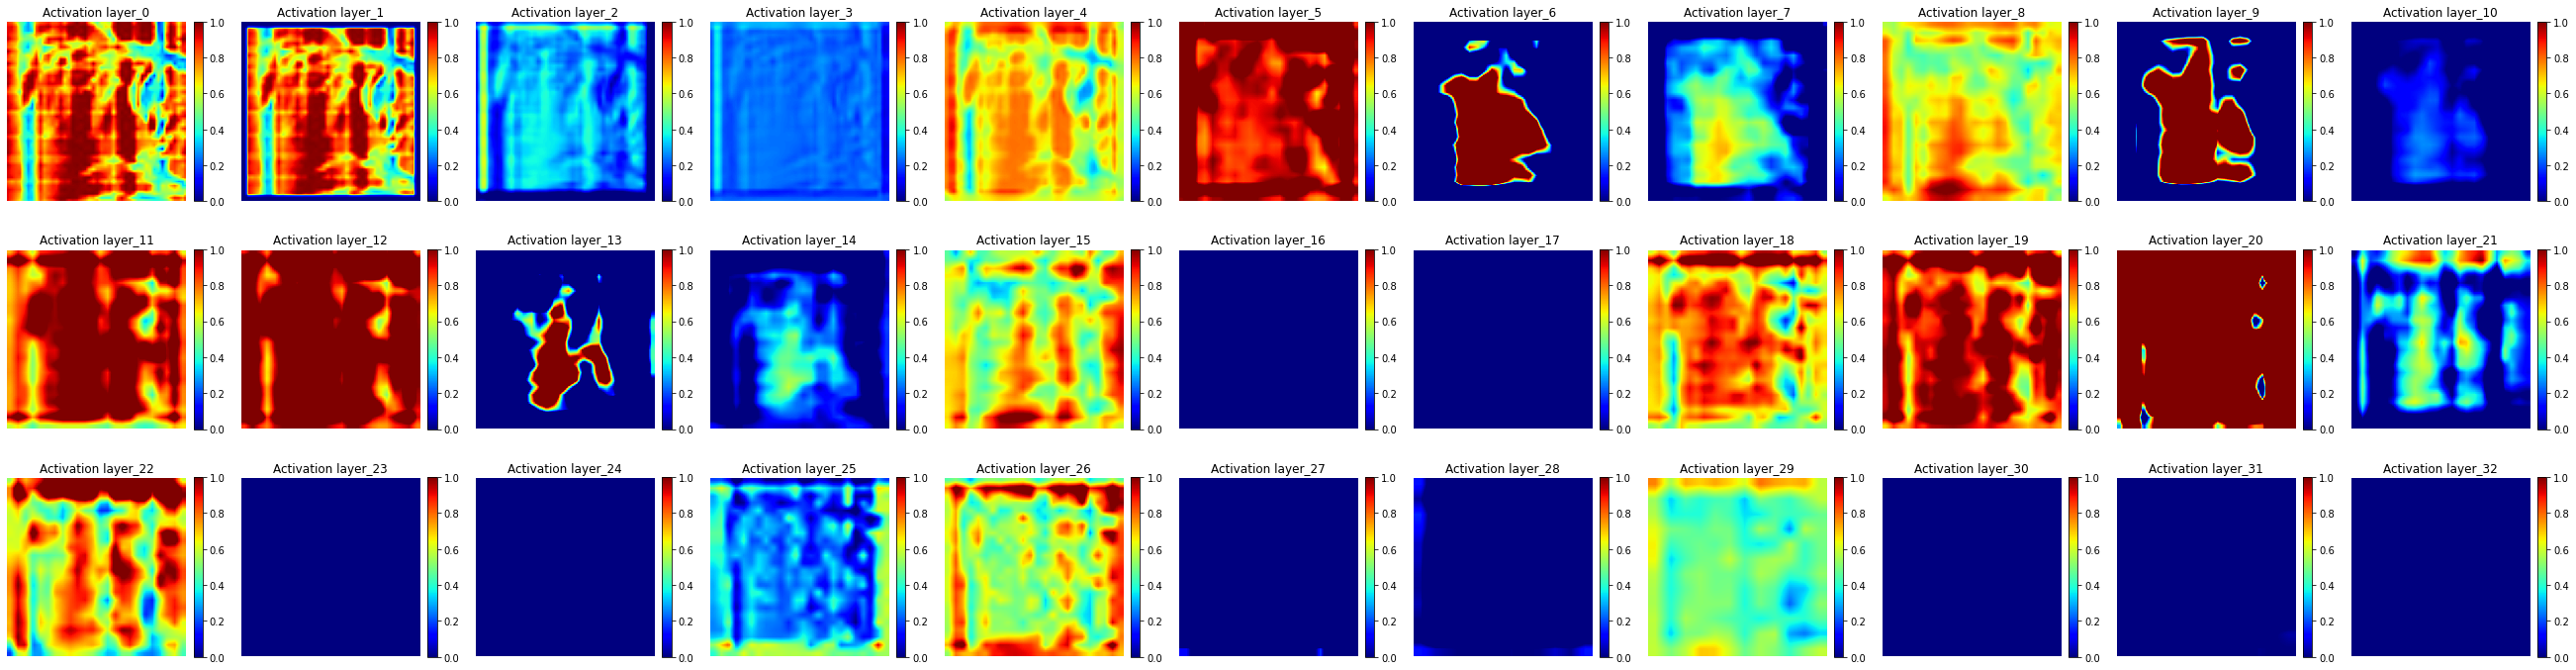

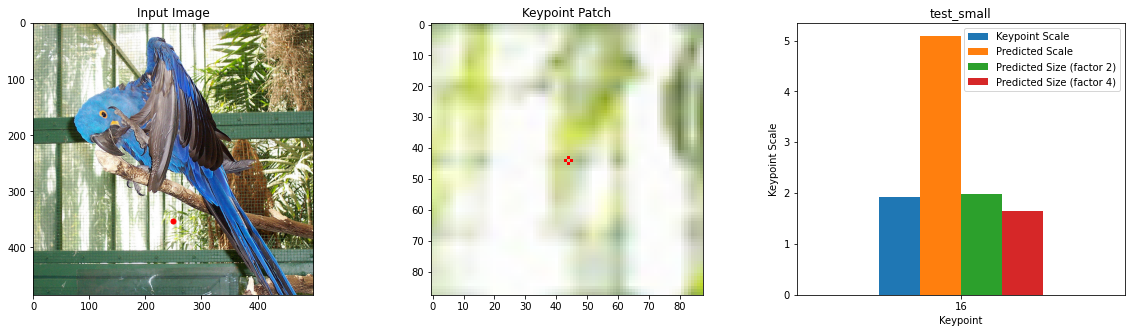

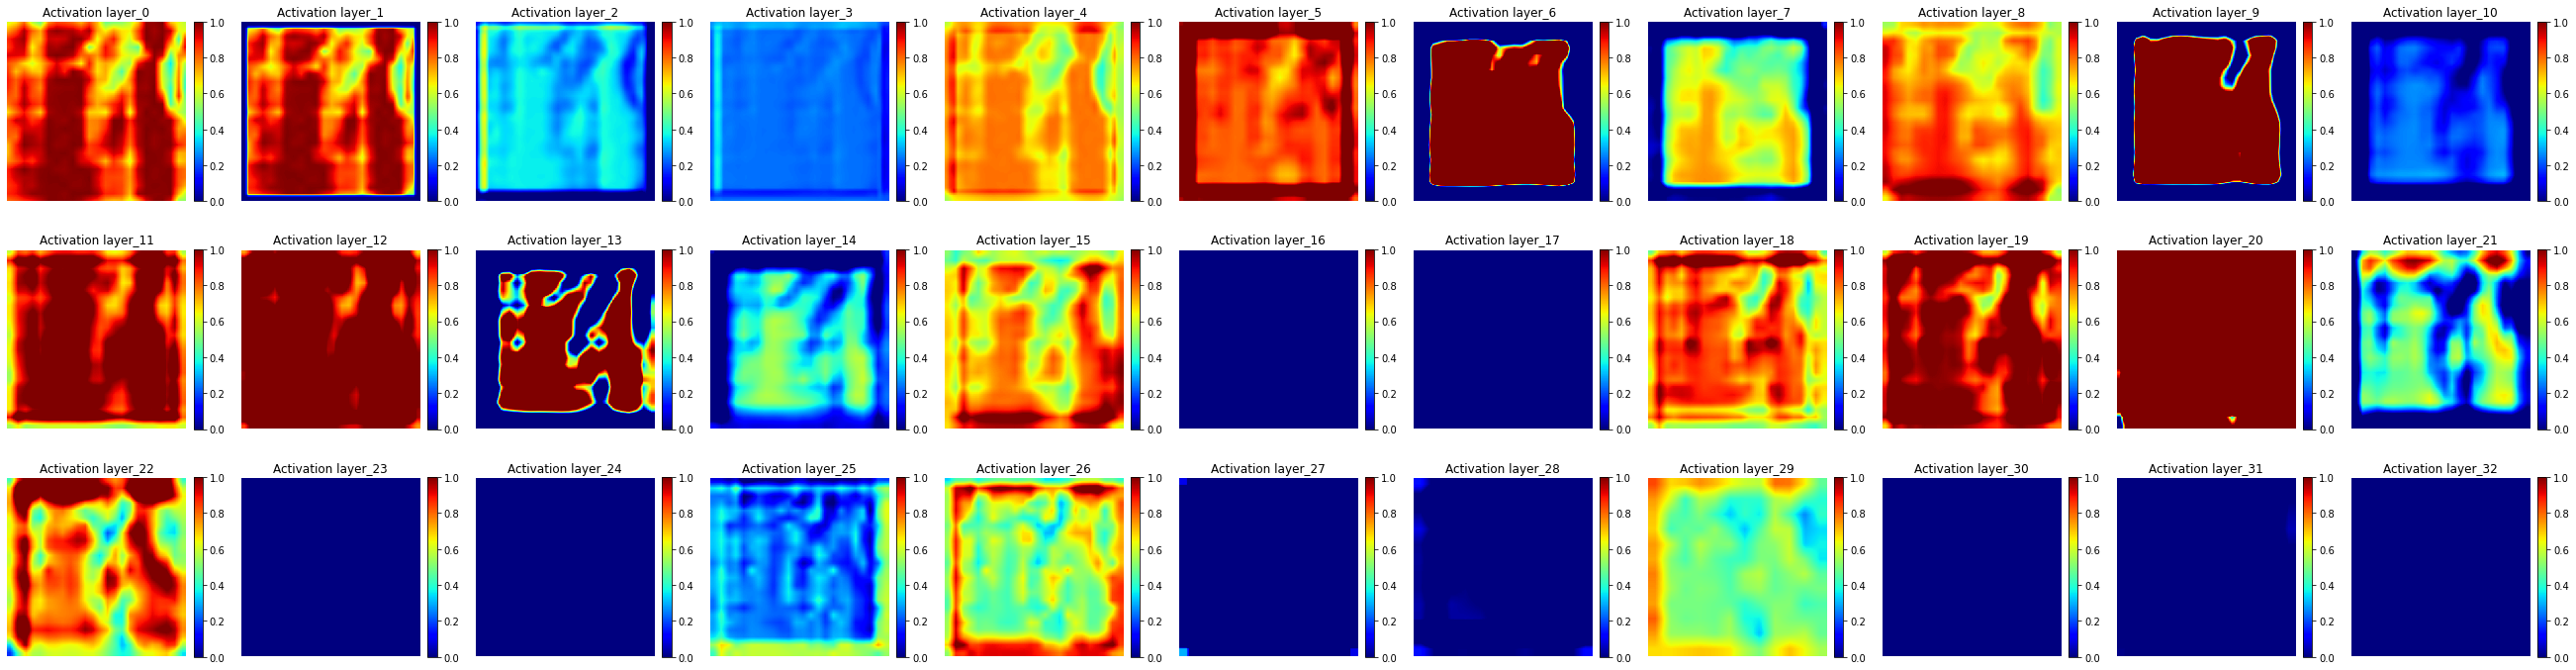

In [694]:
i = 16 #42 #2 #37

act_list = act_vis(test_data_small, df_small, kp=i, title='test_small', zoom=False)
act_list_2 = act_vis(test_data_zoom_2, df_small, kp=i, title='test_small', zoom=True)
act_list_4 = act_vis(test_data_zoom_4, df_small, kp=i, title='test_small', zoom=True)

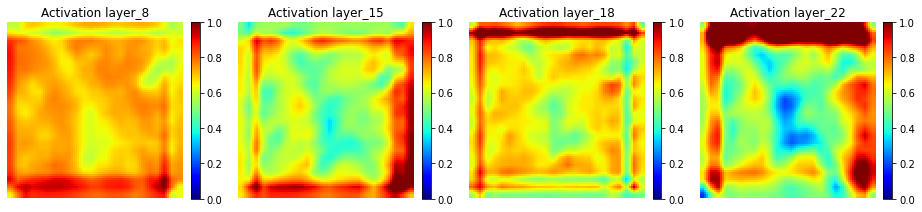

In [685]:
act_list_plt = [8, 15, 18, 22]
a = 3
b = 5    
c = 1
fig = plt.figure(figsize = (20, 20))

for i in act_list_plt:
    plt.subplot(a, b, c)
    plt.imshow(act_list_4[i], vmin=0, vmax=1, cmap='jet')
    plt.title('Activation layer_'+str(i))
    plt.axis('off')
    
    plt.colorbar(fraction=0.046, pad=0.04, cmap='jet')
    c = c+1
    plt.savefig('results/test_small_0_kp_Act_4')
    

In [142]:
layers_act = []
for layer in model.layers:
    if 'Activation' in str(layer): 
        layers_act.append(layer)

In [137]:
activation_model.layers